# Лабораторная работа 4

## Общая информация

**Дата выдачи**: 21.10.2022/24.10.2022

**Срок сдачи**: 04.11.2022/08.11.2022 *(Но требуется обязательная демонстрация текущего прогресса преподавателю во время лабораторного занятия 28.10.2022/31.10.2022)*

### О задании
Целью данного задания является попытка создания собственных признаков (feature engineering), обучение и измерение качества моделей нейронных сетей при помощи фреймворка *Keras*. 

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов.

Сдача заданий после указанного срока сдачи ведёт к снижению оценки.

Задание выполняется САМОСТОЯТЕЛЬНО. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

### Формат сдачи
Устная защита выполненной лабораторной работы ОБЯЗАТЕЛЬНА!

После успешной устной защиты переименуйте получившийся файл `*.ipynb` в соответствии со следующим форматом: *Username_lab_4.ipynb*, где Username — ваша фамилия на латинице (например, `lehusheu_lab_4.ipynb`) и отправьте этот файл электронной почтой по адресу `dmitri.legushev.bsu@gmail.com` c темой письма *Фамилия преподавателя - Лабораторная работа 2 - Фамилия Имя Отчество* (для обоих подгрупп). Подгруппа Атрохова Кирилла Георгиевича также ставит в копию адрес `kiryl.atrokhau+ml2022@gmail.com`. Это будет являться письменным отчетом о выполнении лабораторной работы.

**Задача:** Используя нейронные сети, создать модели, которые предсказывают какой пассажир 
    выжил после крушения на Титанике. 

**Данные:** Титаник

**Подробнее о данных:** https://www.kaggle.com/competitions/titanic/data

In [2]:
#pip install tensorflow --user

In [423]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler,PolynomialFeatures,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.activations import softmax,tanh,relu,sigmoid
from tensorflow.keras.metrics import Accuracy,Precision,AUC,FalseNegatives,FalsePositives,TrueNegatives,TruePositives,MSE
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD,Adam,Adamax
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import L1,L2,L1L2
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from itertools import permutations,product
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

**0.** 
Установить фреймворк Keras. 

Загрузить данные для обучения и теста, найти признаки с пропущенными значениями.

In [424]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [425]:
train.Age = train.Age.fillna(train.Age.median())
train.Cabin = train.Cabin.fillna("Unknown_Cabin")
train.Embarked = train.Embarked.fillna("Unknown_Embarked")
train = train.drop(columns='PassengerId',axis=1)

**1.** Необхоимо расширить датасет новыми признаками. Например, добавить полиномиальные признаки (sklearn.preprocessing.PolynomialFeatures) и/или на основе признаков SibSp, Age, Name, Pclass, Parch, Ticket и др. сформировать новые (Например из признака Age, можно сделать категориальную фичу, например 1-20 - 0, 21-40 - 1, 41-100 - 3; распарсить фичу Name, где можно вычленить информации о статусе человека).

In [426]:
train = train.drop(columns='Ticket',axis=1)

In [427]:
bins = [0,18,50,100]

In [428]:
for i in range(len(bins)-1):
    train.loc[(train.Age>=bins[i]) & ((train.Age<bins[i+1])),'Age'] = i

In [429]:
le_Sex = LabelEncoder()
le_Embarked = LabelEncoder()
train.Sex = le_Sex.fit_transform(train.Sex)
train.Embarked = le_Embarked.fit_transform(train.Embarked)

In [430]:
le_CabinLetter = LabelEncoder()
train.loc[:,'CabinLetter'] = train.Cabin.str.get(0)
train = train.drop(columns='Cabin',axis=1)
train.CabinLetter = le_CabinLetter.fit_transform(train.CabinLetter)

In [431]:
tmp1 = train.Name.str.split(',').str.get(1).str.split('.').str.get(0).str.strip()
tmp2 = test.Name.str.split(',').str.get(1).str.split('.').str.get(0).str.strip()
pd.concat([tmp1,tmp2]).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [432]:
dct = {}
for i in ["Mr","Mrs","Ms","Mme","Miss"]:
    dct[i]="Human"
for i in ["Master", "Don","Lady", "Sir", "the Countes", "Jonkheer","Dona"]:
    dct[i] = "Superhuman"
for i in ['Rev', 'Dr','Major','Mlle', 'Col', 'Capt']:
    dct[i] = "Rank"
train.Name=tmp1
train = train.replace({"Name":dct})


In [433]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit([["Human"],["Superhuman"],["Rank"]])
train[["Human", "Superhuman","Rank"]]=ohe.transform(np.array(train.Name).reshape(-1,1))
train = train.drop(columns='Name',axis=1)

In [384]:
poly_cols = ['Sex','Age','SibSp','Parch']
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
tmp = poly.fit_transform(train[poly_cols])
train = train.drop(columns=poly_cols,axis=1)
train[poly.get_feature_names_out()] = tmp

<AxesSubplot:>

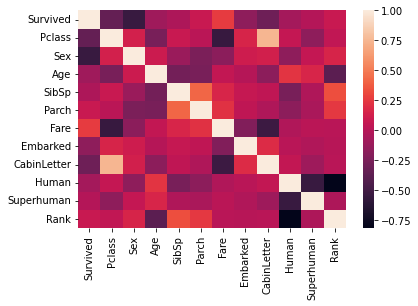

In [434]:
sns.heatmap(train.corr())

**2.** Необходимо нормализовать данные. Для числовых - по одной из стратегий (MinMax, StandartScaler и др.). Для категориальных - применить OneHotEncoder. Разделить полученный датасет на train и validation.

In [435]:
scaler = StandardScaler()
train_copy = train.copy()
train = pd.DataFrame(scaler.fit_transform(train),columns=train.keys())

In [436]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), train_copy.Survived, random_state=42, test_size=20)

**3.** Используя фреймворк Keras необходимо реализовать однослойную и многослойную модель нейронной сети.

Необходимо попробовать:
1) Встроить разные функции активации в слоях (ReLU, sigmoid и др.)

2) Обучить модели на слоях с Dropout и без.

3) Встроить регуляризацию в слои (L1, L2, L1L2)

4) Обучить модели с разными оптимизаторами лоса (SGD, Adam и др.)

5) Обучить модели с подбором learning_rate в оптимизаторах лоса. Попробовать технику step decay.

6) Обучить модели с разным числом эпох. Попробовать callback - EarlyStopping.

Для каждого эксперимента необходимо:
1. Построить графики лоса. 

Отрисовать history (возвращаемый список метода fit), либо для отслеживания обучения в реальном времени можно применить callback - PlotLossesKeras (from livelossplot import PlotLossesKeras). В функции fit указать callbacks=[PlotLossesKeras()].


2. Снять метрики (не только accuracy, но и f1, recall, precision. **Tip**: sklearn) 

Также можно отслеживать метрики во время обучения: metrics=[tf.keras.metrics.Precision(), ..].

3. Сделать выводы.

**Tips**: Очень важно недопустить переобучения моделей. Для этого необходимо:

1) Так как данных не так уж и много, то не делать слишком много слоев (мы ограничиваемся 2-3 слоями).

2) Не указывать число эпох слишком большим (10-20-30). На графике функции потерь можно отследить на какой эпохе тренировочные данные начинают "заучивать" данные, а на графике валидационного лоса происходит рост функции потерь. Для этого применяют раннюю остановку обучения - EarlyStopping.

3) Применять Dropout, регуляризации L1/L2/L1L2.



In [19]:
MSE??

In [330]:
#metrics = [Precision(),AUC(),FalseNegatives(),FalsePositives()]
metrics= []

In [147]:
model = Sequential(
    [
        Dense(units=16,input_dim=X_train.shape[1], activation=relu,kernel_regularizer=L1L2(1e-4,1e-4)),
        Dense(units=1, activation=sigmoid)
    ]   
)

In [195]:
#0.789
model = Sequential(
    [
        Dense(units=16,input_dim=X_train.shape[1], activation=relu,kernel_regularizer=L1L2(1e-3,1e-4)),
        Dense(units=64, activation=relu,kernel_regularizer=L1L2(1e-3,1e-4)),
        Dropout(0.3),
        Dense(units=8, activation=relu,kernel_regularizer=L1L2(1e-3,1e-4)),
        Dropout(0.3),
        Dense(units=1, activation=sigmoid)
    ]   
)

In [447]:
model = Sequential(
    [
        Dense(units=32,input_dim=X_train.shape[1], activation=relu,kernel_regularizer=L1L2(1e-4,1e-5)),
        Dropout(0.3),
        Dense(units=64, activation=relu,kernel_regularizer=L1L2(1e-4,1e-5)),
        Dropout(0.5),
        Dense(units=1,activation=sigmoid)
    ]   
)

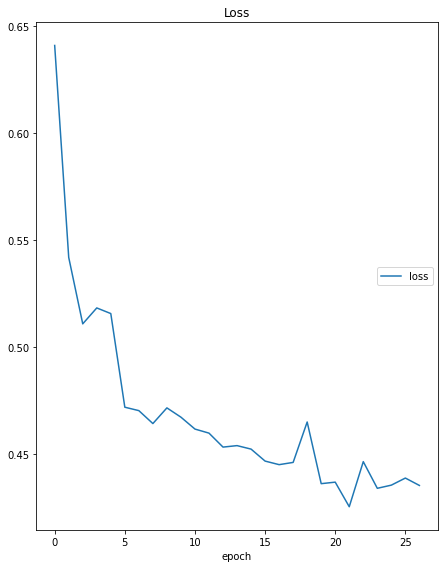

Loss
	loss             	 (min:    0.425, max:    0.641, cur:    0.435)


In [448]:
"""
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
"""

model.compile(loss=BinaryCrossentropy(), optimizer=Adam(),metrics=metrics)

callback = EarlyStopping(monitor='loss', patience=5)

history = model.fit(X_train, y_train, epochs=150, batch_size=5,verbose=0,callbacks=[PlotLossesKeras(),callback])
#y = history.history['accuracy']
#x = list(range(len(y)))

In [449]:
tmp = model.predict(X_test).reshape(1,-1)[0]
pred = np.array(tmp>0.5,dtype='int32')
print(classification_report(pred,y_test))
print(MSE(y_test,tmp).numpy())
print(sum((tmp-0.5)**2))

1/1 [==============================] - 0s 53ms/step
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

0.060400955
2.294612195342779


In [450]:
for i,j in zip(*[tmp,y_test]):
    print(j,i)

1 0.8024596
0 0.14738369
0 0.11139527
1 0.94336116
1 0.7672175
1 0.9808812
1 0.67052096
0 0.06073717
1 0.77561355
1 0.9711227
0 0.42255726
0 0.11157672
0 0.25587094
0 0.16387932
0 0.15170737
1 0.9857014
1 0.42015034
1 0.6708707
0 0.08126771
0 0.39493063


**4.** Отправить лучший результат на https://www.kaggle.com

In [437]:
test = pd.read_csv('data/test.csv')

In [438]:
test.Age = test.Age.fillna(test.Age.median())
test.Cabin = test.Cabin.fillna("Unknown_Cabin")
test.Embarked = test.Embarked.fillna("Unknown_Embarked")
for i in test.Pclass.unique():
    test.loc[test.Pclass==i,'Fare'] = test.loc[test.Pclass==i,'Fare'].fillna(test.loc[test.Pclass==i,'Fare'].median())
PasId = test.PassengerId
test = test.drop(columns='PassengerId',axis=1)

test = test.drop(columns='Ticket',axis=1)



In [439]:
bins = [0,18,50,100]
for i in range(len(bins)-1):
    test.loc[(test.Age>=bins[i]) & ((test.Age<bins[i+1])),'Age'] = i

test.Sex = le_Sex.transform(test.Sex)
test.Embarked = le_Embarked.transform(test.Embarked)

test.loc[:,'CabinLetter'] = test.Cabin.str.get(0)
test = test.drop(columns='Cabin',axis=1)
test.CabinLetter = le_CabinLetter.fit_transform(test.CabinLetter)



tmp2 = test.Name.str.split(',').str.get(1).str.split('.').str.get(0).str.strip()
test.Name=tmp2
test = test.replace({"Name":dct})

In [440]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit([["Human"],["Superhuman"],["Rank"]])
test[["Human", "Superhuman","Rank"]]=ohe.transform(np.array(test.Name).reshape(-1,1))
test = test.drop(columns='Name',axis=1)

In [392]:
tmp = poly.transform(test[poly_cols])
test = test.drop(columns=poly_cols,axis=1)
test[poly.get_feature_names_out()] = tmp

In [441]:
scaler = StandardScaler()
test_copy = test.copy()
test = pd.DataFrame(scaler.fit_transform(test),columns=test.keys())

<AxesSubplot:>

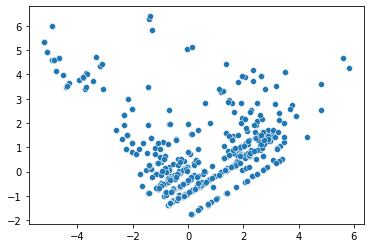

In [442]:
tmp = PCA(n_components=2).fit_transform(X_train)
sns.scatterplot(x=tmp[:,0],y=tmp[:,1])

<AxesSubplot:>

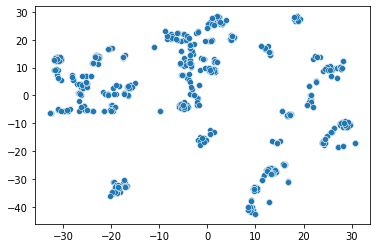

In [443]:
tmp = TSNE(n_components=2,learning_rate='auto',init='random').fit_transform(X_train)
sns.scatterplot(x=tmp[:,0],y=tmp[:,1])

In [452]:
ypred_Xnew - np.array(model.predict(test).reshape(1,-1)[0]>0.5,dtype='int32')

14/14 [==============================] - 0s 1ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [451]:
ypred_Xnew = np.array(model.predict(test).reshape(1,-1)[0]>0.5,dtype='int32')

14/14 [==============================] - 0s 1ms/step


In [446]:
submission = pd.DataFrame({'PassengerId': PasId, 'Survived': ypred_Xnew })
submission.to_csv("submission.csv", index=False)

Help links:
- https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
- https://keras.io/about/
- https://keras.io/guides/sequential_model/
- https://keras.io/api/layers/
- https://keras.io/api/callbacks/
- https://keras.io/api/optimizers/
- https://keras.io/api/losses/
- https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
- https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/